# Week 5
## Overview

This week we'll talk about advanced network measures (beyond the degree distribution). We will use these tools to make sense of the network of the Rock Musicians on Wikipedia. 
This is the outline for today:

* Visualization and qualitative analysis of the Rock Music Artists Network
* Properties of the network structure
* Finally some more visualizations

> _Reading_: This week, the reading is mostly for reference. It's for you to have a place to go, if you want more detailed information about the topics that I cover in the video lectures. Thus, I recommend you check out **Chapter 9** of the network science book. In particular, we'll delve into Section 9.4 in the exercises below. We will also talk a little bit about degree correlations - you can read about those in **Chapter 7**.

# Part A: Let's  visualise some more!

For the rest of the course, we will primarily use[`ForceAtlas2`](https://journals.plos.org/plosone/article%3Fid=10.1371/journal.pone.0098679), a layout algorithm which was developed by the creators of the [Gephy graph analysis software](https://gephi.org). IMHO it's the prettiest network layout algorithm & since last year it's been implemented in NetworkX, so it should be easy to use.

*Exercise 1:* Plot the Network using ForceAtlas2. For visualization, you should work with the network from last time, the Giant Connected Component ... and the undirected version.

> * Visualize the network using NetworkX
>   * Node color should depend on the `length_of_content` attribute (see notes from last week).
>   * Node size should depend on the node *degree*
> * Play with the force atlas algorithm parameters to obtain a visualization you like. 

<div class="alert alert-block alert-info">
It's OK to use your LLM as much as needed for this exercise. The only goal is to create a nice visualization.
</div>

In [5]:
import requests
import os
from urllib.parse import quote
import time
import json
from pathlib import Path
import numpy as np
import re
#We made a wikipediadownloader class that downloads and saves the json version of a wikipedia page

class WikipediaDownloader:
    def __init__(self):
        self.base_url = "https://en.wikipedia.org/w/api.php"

        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        })

    def download_page_html(self, title):
        try:
            params = {
                "action": "query",
                "prop": "revisions",
                "rvprop": "content",
                "format": "json",
                "titles": title.replace(' ', '_'),  # Use the actual title parameter
                "rvslots": "main"
            }
            print(f"Downloading: {title}")
            response = self.session.get(self.base_url, params=params)

            response.raise_for_status()
            return response.text
        except requests.RequestException as e:
            print(f"Error downloading {title}: {e}")
            return None

    def save_page(self, title, content):
        if content is None:
            return False

        # Create directory if it doesn't exist
        os.makedirs("wikipedia_pages", exist_ok=True)

        # Clean filename
        safe_filename = "".join(c for c in title if c.isalnum() or c in (' ', '-', '_')).rstrip()
        filename = f"wikipedia_pages/{safe_filename}.json"

        try:
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(content)
            print(f"Saved: {filename}")
            return filename
        except IOError as e:
            print(f"Error saving {title}: {e}")
            return False

    def download_and_save(self, title):
        content = self.download_page_html(title)

        if content:
            return self.save_page(title, content)
        return False

downloader = WikipediaDownloader()

favorite_pages = [
    "List of mainstream rock performers"
]
for page_title in favorite_pages:
    print(f"\n--- Processing: {page_title} ---")

    # Download HTML version
    file_name = downloader.download_and_save(page_title)
    if(file_name):
        print(f"Successfully downloaded and saved: {file_name}")
    else:
        print(f"Failed to download or save: {page_title}")


--- Processing: List of mainstream rock performers ---
Downloading: List of mainstream rock performers
Saved: wikipedia_pages/List of mainstream rock performers.json
Successfully downloaded and saved: wikipedia_pages/List of mainstream rock performers.json


In [6]:
import networkx as nx
nx.__version__

'3.5'

In [7]:
#We extracted the artists from the mainstreem rock performers wiki
import json
with open("wikipedia_pages/List of mainstream rock performers.json", "r") as f:
    html_content = f.read()

#we had to decode the json because of the special characters
parsed_json = json.loads(html_content)
page_id = list(parsed_json['query']['pages'].keys())[0]
wiki_text = parsed_json['query']['pages'][page_id]['revisions'][0]['slots']['main']['*']

# Now extract from the properly decoded text
pattern = r'\[\[([^\]|]+)'

In [8]:

import re
# Find the artists and saved them to the artists.txt
matches = re.findall(pattern, wiki_text)

# Optional: remove duplicates and sort
artists = sorted(set(matches))

# Save to a text file
with open("artists.txt", "w", encoding="utf-8") as f:
    for artist in artists:
        f.write(artist + "\n")

print(f"Extracted {len(artists)} artists and saved to artists.txt")

Extracted 492 artists and saved to artists.txt


In [9]:
# Open the file in read mode
artists_file_names = []
with open("artists.txt", "r", encoding="utf-8") as file:
    for line in file:
        artist = line.strip()  # remove leading/trailing spaces and newline
        file_name = downloader.download_and_save(artist)
        if(file_name):
            artists_file_names.append(file_name)
        else:
            print(f"Failed to download or save: {page_title}")

Downloading: 10 Years (band)
Saved: wikipedia_pages/10 Years band.json
Downloading: 10cc
Saved: wikipedia_pages/10cc.json
Downloading: 3 Doors Down
Saved: wikipedia_pages/3 Doors Down.json
Downloading: 311 (band)
Saved: wikipedia_pages/311 band.json
Downloading: 38 Special (band)
Saved: wikipedia_pages/38 Special band.json
Downloading: A Perfect Circle
Saved: wikipedia_pages/A Perfect Circle.json
Downloading: ABBA
Saved: wikipedia_pages/ABBA.json
Downloading: AC/DC
Saved: wikipedia_pages/ACDC.json
Downloading: AFI (band)
Saved: wikipedia_pages/AFI band.json
Downloading: Accept (band)
Saved: wikipedia_pages/Accept band.json
Downloading: Adam Ant
Saved: wikipedia_pages/Adam Ant.json
Downloading: Aerosmith
Saved: wikipedia_pages/Aerosmith.json
Downloading: Air Supply
Saved: wikipedia_pages/Air Supply.json
Downloading: Alanis Morissette
Saved: wikipedia_pages/Alanis Morissette.json
Downloading: Alice Cooper
Saved: wikipedia_pages/Alice Cooper.json
Downloading: Alice Cooper (band)
Saved: wi

In [10]:
#we saved the artists to an artist_array so that it will be easier to iterate through them later
artist_array = []
with open("artists.txt", "r", encoding="utf-8") as file:
    for line in file:
        artist_array.append(line.strip())  # remove leading/trailing spaces and newline

In [11]:
# We made a function that checks if an artist is referenced in another artist's wikipedia page
def find_referenced_artists(artist_to_find, current_artist, current_artist_file_name):
    file_path = current_artist_file_name
    with open(file_path, "r", encoding="utf-8") as f:
        wiki_html = f.read()

    # Find all wiki links with regex
    pattern = r"\[\[" + re.escape(artist_to_find) + r"(?:\|[^\]]+)?\]\]"

    if re.search(pattern, wiki_html):
        return True
    else:
        return False

In [12]:
#We made a directed graph and added the artists as nodes and if an artist referenced another artist in his wikipedia page we added a directed edge from the first artist to the second artist.
import networkx as nx
rock_artists_graph = nx.DiGraph()

for artist in artist_array:
    rock_artists_graph.add_node(artist)

for index in range (len(artist_array)):
    artist = artist_array[index]
    artist_file_name = artists_file_names[index]
    for artist_to_find in artist_array:
        if artist != artist_to_find:
            if find_referenced_artists(artist_to_find, artist, artist_file_name):
                rock_artists_graph.add_edge(artist, artist_to_find)

In [ ]:
#after analysing the data, we found a couple of strings that needed to be removed
rock_artists_graph.remove_node('Category:Lists of rock musicians')
rock_artists_graph.remove_node('Category:Lists of rock musicians by subgenre')
rock_artists_graph.remove_node('AllMusic')
rock_artists_graph.remove_node('rock music')


In [14]:
#We made a helper function that extracts the text from the Wikipedia json structure
#We used llm to help us with this 2 functions
def extract_wiki_text(data):
    pages = data["query"]["pages"]
    first_page = next(iter(pages.values()))
    return first_page["revisions"][0]["slots"]["main"]["*"]

#We made a function that returns the number of words in a json file based on the regex as below
def word_count(current_artist_file_name):
    file_path = Path(current_artist_file_name)
    with file_path.open("r", encoding="utf-8") as f:
        data = json.load(f)

    text = extract_wiki_text(data)

    text = re.sub(r"\s+", " ", text).strip()

    words = re.findall(r"\b[\w’-]+\b", text, flags=re.UNICODE)

    return len(words)

In [15]:
#We connect the artists_file_names with the artist_arrays to create a dictionary
artists_to_path = dict(zip((artist_array), (artists_file_names)))

word_count_array = []
for artist in rock_artists_graph.nodes():
    file_path = artists_to_path[artist]
    word_num = word_count(file_path)
    word_count_array.append(word_num)

In [16]:
artists_to_dict = {}
for index, item in enumerate(list(rock_artists_graph.nodes.items())):
    artists_to_dict[item[0]] = word_count_array[index]

nx.set_node_attributes(rock_artists_graph, values = artists_to_dict, name = "word_count")

In [17]:
#We made a function that disconnect nodes that don't have any edges
def disconnect_node(graph_name):
    nodes_with_no_out_degree = []
    for node in graph_name:
        if graph_name.out_degree(node) == 0 and graph_name.in_degree(node) == 0:
            nodes_with_no_out_degree.append(node)

    graph_name.remove_nodes_from(nodes_with_no_out_degree)
    disconnected = nodes_with_no_out_degree
    return disconnected

disconnect = disconnect_node(rock_artists_graph)
print(f"Disconnected nodes: ", disconnect)

Disconnected nodes:  ['Dr. Hook & the Medicine Show', 'Jet (Australian band)', "The B-52's", 'Van Zant (band)']


In [18]:
#We search for the largest component
largest_component_sort = sorted(nx.weakly_connected_components(rock_artists_graph), key=len, reverse=True)
largest_component = rock_artists_graph.subgraph(largest_component_sort[0])

# add who is the largest component with number of edges and nodes

largest_component_nodes = largest_component.number_of_nodes()
print(f"The number of nodes of the largest component is: ", largest_component_nodes)

#number of links
largest_component_edges = largest_component.number_of_edges()

print("The number of links in the largest component is:", largest_component_edges)

The number of nodes of the largest component is:  485
The number of links in the largest component is: 7507


In [19]:
#import pickle
#with open("../files/rock_artists.p", 'wb') as f:
#    pickle.dump(rock_artists_graph, f)

In [20]:
# #load the rock artists graph
# with open("../files/rock_artists.p", 'rb') as f:  # notice the r instead of w
#     rock_artists_graph = pickle.load(f)

In [21]:
nx.forceatlas2_layout(rock_artists_graph)

{'10 Years (band)': array([  -51.825542, -1589.3605  ], dtype=float32),
 '10cc': array([  348.815 , -2009.8723], dtype=float32),
 '3 Doors Down': array([   63.37053, -1746.0721 ], dtype=float32),
 '311 (band)': array([  373.36108, -2028.9192 ], dtype=float32),
 '38 Special (band)': array([  333.2848, -1939.8094], dtype=float32),
 'A Perfect Circle': array([  181.33339, -1755.9512 ], dtype=float32),
 'ABBA': array([  415.57498, -2263.8542 ], dtype=float32),
 'AC/DC': array([   41.540733, -2100.6528  ], dtype=float32),
 'AFI (band)': array([  526.0959, -1746.9473], dtype=float32),
 'Accept (band)': array([  111.23437, -1901.7206 ], dtype=float32),
 'Adam Ant': array([  961.63824, -1970.6193 ], dtype=float32),
 'Aerosmith': array([   70.44704, -2067.6768 ], dtype=float32),
 'Air Supply': array([  627.90045, -2106.745  ], dtype=float32),
 'Alanis Morissette': array([  589.57855, -1950.0731 ], dtype=float32),
 'Alice Cooper': array([  534.9539, -2069.3447], dtype=float32),
 'Alice Cooper (b

*Exercise 2*: We continue with a qualitative inspection of the Wikipedia pages. Inspecting the data manually will develop intuitions that will help us to intepret our quantitative results. We investigate the reasons for links between characters to exist on Wikipedia.

> 1. Consider the nodes with highest in-degree in the network. Open the corresponding Wikipedia page.
>    * Consider the set of neighbours pointing towards the node found above. 
>    * What is the relation between the band/mucisians you identified and their network neighbours? (e.g. did they sing a song together, did one write a song for the other?, etc ...). You don't need to come up with a grand theory of Rock Music here, I just want you to think about how links arise, why the links are there.
>    * Repeat the exercise for the highest out-degree node. 
>    * Are there differences between reasons for out- and in-links? Again, there's no right answer here. I just want you to think about some of the reasons why links may occur in Wikipedia. Answer in your own words.
> 4. Create a scatter plot, where each node is a point, and the axes show in- versus out-degree. That way you can visually inspect the patterns of how in- and out-degree are connected across all the nodes in the network. Comment on what you see.
> 5. Are there any nodes with high(ish) out-degree and with few incoming connections? If yes, open WikiPages of those bands/mucisians and explain what happens?
> 6. Are there any nodes with high in-degree and few going connections? Again, open the WikiPages corresponding to those nodes and explain what happens?

<div class="alert alert-block alert-info">
For this one, I hope you'll limit your LLM use. It's OK to get help in creating the scatter plot, but use NetworkX on your own to identify nodes, and do your own reading and interpreting of Wiki pages.
</div>

# Part B:  Advanced tools 

> **Video lecture**: *Network measures*. There's an updated video below, and if you can't get enough, you can watch the original version from 2015 [here](https://www.youtube.com/watch?v=0uAYpOqVHCU).

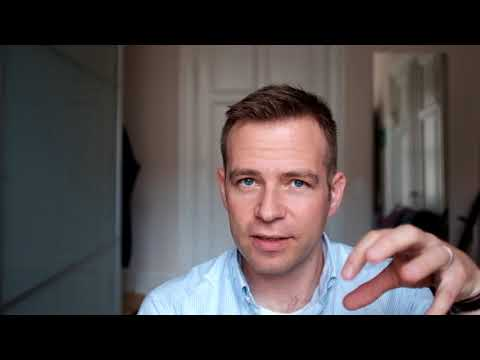

In [22]:
from IPython.display import YouTubeVideo
YouTubeVideo("IOWXZFOyk9Y", width=800, height=450)

*Exercise 3:* Last time we visually analyzed (plotted) the degree distributions of our network. Now, let's analyze it using some of the tools from previous lectures. For this exercise we are going to look at the *directed* graph (rememeber, we asked you to keep one?).

> 1. What are the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree? How do you intepret the results?
> 2. Let's also look at the *[exponent of the degree distribution](http://networksciencebook.com/chapter/4#degree-exponent)* 
>    * To calculate it, you can install [`powerlaw`](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777) package (I could not install in conda, so I used `pip install powerlaw`)
>    * Use `powerlaw.Fit(degree).alpha` for fitting
>    * Find the degree exponent for in-, out- and total- degree distribution. Think about what you learned in the book - what does each exponent say about our network?
>    * When analyzing the plots of in- and out- degree distribution last week, did you come up to the same conclusions?
>    * Reflect on the whole power-law thing. Are the degree distributions even power laws? Could a log-normal or exponential distribution be better? How would you find out what the right function to describe the various degree distributions are? 
>    * A long time ago, a group of scientists analyzed the network spanned by **all** of Wikipedia (the paper is called [Wikipedias: Collaborative web-based encyclopedias as complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.74.016115); to access this paper, use findit.dtu.dk or read the preprint on [arXiv](https://arxiv.org/abs/physics/0602149)). Do your findings correspond to the results described in Chapter **III.A** of that paper? If not, try to give your explanation of why? 
> 3. Plot a heatmap [(Hint here)](https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set) of the the in- versus out- degree for all characters. Zoom in on just the in-degree $[0,20]$ and out-degree $[0,20]$ area of the plot. What is the advantage of using a heatmap over the scatter plot from the previous Exercise (especially for understanding what's going on in this area)?
> 4. Why do you think I want you guys to use a directed graph? Are there questions we can ask using the directed graph that are not possible to answer in the undirected version? Which questions? Can you think of examples when the in/out distinction doesn't matter.
> 5. We have one more metric that we have used, but not investigated so far. The node-attribute `length_of_content`. There are two things to look at.
>    * Firstly, we can verify that more text means more links. If that's true the length should correlate with out-degree. Does it? 
>    * Secondly, and more interestingly, it could be that longer texts means *more famous* characters. And that means more in-links. 
>    * How should you test this? Well, here you are allowed to be **creative**. You may choose the method of your liking to study this question (e.g. look at it visually, test the correlation using [spearman](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) or [pearson](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html) correlations, fit a curve to the data, you decide). Are both questions true? If yes, which phenomenon is stronger? Explain your results in your own words.

<div class="alert alert-block alert-info">
For this exercise, I also hope you'll limit your LLM use. Especially for the intrepretation parts. It's OK to get help for the heatmap in sub-part 3, maybe also for ideas of how to do the testing in part 5. But do your own interpretation :)
</div>

*Exercise 4:* Centralities, assortativity and more.

Earlier, we found the most connected nodes (using degree centrality). 

Now let's dig in and try to understand more about the network using more advanced features. 

**Note**: Not all of the measures we'll be considering below are defined for directed graphs. Only use the undirected graph when explicitly stated in the exercise. 
> 1. Find the 5 most central characters according to degree centrality. 
> 1. Find the 5 most central characters according to betweenness centrality. 
>    * Repeat Exercise 1 (plotting the network). However, this time use *betweenness centrality* to define the size of the node.
>    * What role do you imagine characters with high wikipedia graph betweenness centrality play in the network? 
> 2. Find the 5 most central characters according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). 
>    * Repeat Exercise 1 one final time (depending on which visualization method you liked the most). However, this time use eigenvector centrality to define the size of the node.
>    * What role do you imagine characters with high wikipedia graph eigenvector centrality play? Describe what is different about betweenness centrality and eigenvector centrality using your visualizations as examples.
> 3. Plot the betweenness centrality of nodes vs their degree centrality. Is there a correlation between the two? Did you expect that? Why? 
>     * Repeat the scatter plot using eigenvector centrality instead of betweenness centrality. Do you observe any difference relative to above? Why?
> 4. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect to degree? (e.g. do high-degree characters tend to link to other high-degree characters, and low-degree characters to other low-degree characters?). Provide an interpretation of your answer.
> 5. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect do the `length_of_content` nodal properties? (e.g. do characters with long Wikipedia pages tend to link to other charakters with long Wiki-pages, and *vice versa*?.
>      * Hint: Use [this function](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html#networkx.algorithms.assortativity.attribute_assortativity_coefficient). Provide an interpretation of your answer.
> 6. What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes $N$  and probablity of connection $p$?
>    * Take a look at the *distribution* of shortest paths for the two networks (create a histogram for each network) to better compare and contrast. Explain what you see in your own words.

<div class="alert alert-block alert-info">
As in the two previous exercises, I hope you'll limit your LLM use. Try to get a sense of working with NetworkX. And to grow your brain, do your own intrepretation parts ... it's difficult, but that's how you grow.</div>

 # Eni part

## Part A

### Network analysis

In [107]:
n_nodes = rock_artists_graph.number_of_nodes()
n_edges = rock_artists_graph.number_of_edges()
print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")

print("Is directed:", nx.is_directed(rock_artists_graph))

rock_artists_graph = rock_artists_graph.to_undirected()

largest_cc_nodes = max(nx.connected_components(rock_artists_graph_undirected), key=len)
giant_connected_component = rock_artists_graph_undirected.subgraph(largest_cc_nodes).copy()

print(f"GCC nodes: {giant_connected_component.number_of_nodes()}")
print(f"GCC edges: {giant_connected_component.number_of_edges()}")
print(f"GCC density: {nx.density(giant_connected_component):.4f}")

density = nx.density(rock_artists_graph)
avg_degree = sum(dict(rock_artists_graph.degree()).values()) / n_nodes

print(f"Network density: {density:.4f}")
print(f"Average degree: {avg_degree:.2f}")


Number of nodes: 484
Number of edges: 7247
Is directed: True
GCC nodes: 484
GCC edges: 5981
GCC density: 0.0512
Network density: 0.0512
Average degree: 24.71


Our directed network contains 485 nodes and 7507 edges. Each node represents a rock band, and the edges corresponds to hyperlinks between their Wikipedia pages. For analysis we often use its largest undirected connected component (GCC), which includes 485 nodes and 6215 edges, with a density of 0.53.
Overall, the network is sparse, it's density is around 0.03, and the average degreeof approximately 31, indicates that most artists are connected to a moderate number of others, while a few very connected hubs likely dominate its structure.

In [60]:
#assortavity coefficient of the network

assortavity_coefficient = nx.degree_assortativity_coefficient(rock_artists_graph)
print("The assortavity coefficient of the original network based on betweenness centrality is: ", assortavity_coefficient)

The assortavity coefficient of the original network based on betweenness centrality is:  -0.03537818358277061


In [23]:
print(f"\nThe neighbours of the top in_degree artists are:")

top5_in_degree = sorted(rock_artists_graph.in_degree(), key=lambda x: x[1], reverse=True)[:5]

top_artist_in_degree = top5_in_degree[0]
top_artist_in_neighbours = list(rock_artists_graph.neighbors(top_artist_in_degree[0]))
for i in top_artist_in_neighbours:
    print(i)
    


The neighbours of the top in_degree artists are:
ABBA
Aerosmith
Alter Bridge
Bad Company
Black Sabbath
Deep Purple
Jack White
Janis Joplin
Jethro Tull (band)
Joy Division
Kings of Leon
Megadeth
Neil Young
Nirvana (band)
Pearl Jam
Phil Collins
Queen (band)
Ramones
Robert Plant
Rush (band)
Scorpions (band)
Skid Row (American band)
Soundgarden
Steve Winwood
The Who
The Yardbirds
Tool (band)
Yes (band)
rock music


In [24]:
print(f"\nThe neighbours of the top in_degree artists are:")
top5_out_degree = sorted(rock_artists_graph.out_degree(), key=lambda x: x[1], reverse=True)[:5]

top_artist_out_degree = top5_out_degree[0]
print(f"The top artist with the most out degree: ", top_artist_out_degree[0])
top_artist_out_neighbours = list(rock_artists_graph.neighbors(top_artist_out_degree[0]))
for i in top_artist_out_neighbours:
    print(i)
    


The neighbours of the top in_degree artists are:
The top artist with the most out degree:  rock music
3 Doors Down
311 (band)
AC/DC
Adam Ant
Aerosmith
Alice Cooper
Alice in Chains
America (band)
Anthrax (American band)
Arcade Fire
Arctic Monkeys
Beastie Boys
Beck
Bee Gees
Bill Haley & His Comets
Billy Joel
Black Sabbath
Blink-182
Blondie (band)
Bloodhound Gang
Blur (band)
Bo Diddley
Bob Dylan
Bob Seger
Bon Jovi
Boston (band)
Bring Me the Horizon
Bruce Springsteen
Buddy Holly
Bush (British band)
Canned Heat
Chicago (band)
Chubby Checker
Chuck Berry
Coldplay
Collective Soul
Cream (band)
Creed (band)
Creedence Clearwater Revival
Dashboard Confessional
David Bowie
Deep Purple
Def Leppard
Dire Straits
Disturbed (band)
Donovan
Duane Eddy
Duran Duran
Eagles (band)
Electric Light Orchestra
Elton John
Elvis Costello
Elvis Presley
Emerson, Lake & Palmer
Eric Clapton
Faith No More
Fall Out Boy
Fats Domino
Fleetwood Mac
Foo Fighters
Foreigner (band)
Frank Zappa
Franz Ferdinand (band)
Gary Glitter

In [25]:
rock_artists_graph_attributes ={"graph":rock_artists_graph, "in_degrees":[], "out_degrees":[], "min_degree":0, "max_degree":0}

scale_free_graph_attributes = {"graph":nx.scale_free_graph(rock_artists_graph.number_of_nodes()), "in_degrees":[], "out_degrees":[], "min_degree":0, "max_degree":0}

random_graph_attributes = {"graph":nx.gnm_random_graph(rock_artists_graph.number_of_nodes(), rock_artists_graph.number_of_edges(), directed=True), "in_degrees":[], "out_degrees":[], "min_degree":0, "max_degree":0}


graphs = [rock_artists_graph_attributes, scale_free_graph_attributes, random_graph_attributes]

for graph in graphs:
    in_degrees_array = []
    out_degrees_array = []
    for node in graph["graph"].nodes():
        in_degree = graph["graph"].in_degree(node)
        out_degree = graph["graph"].out_degree(node)
        in_degrees_array.append(in_degree)
        out_degrees_array.append(out_degree)
    graph["in_degrees"] = in_degrees_array
    graph["out_degrees"] = out_degrees_array
    degrees = dict(graph["graph"].degree())
    graph["min_degree"] = min(degrees.values())
    graph["max_degree"] = max(degrees.values())


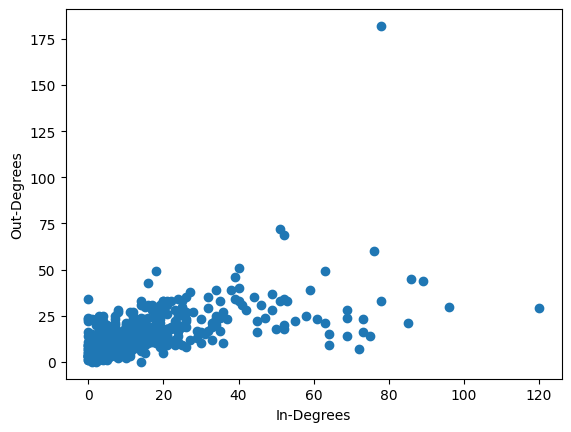

**Figure xx.:** *The relationship between in- and out-degrees of all nodes.

In [66]:
import matplotlib.pyplot as plt
import numpy as np

x_values = rock_artists_graph_attributes["in_degrees"]
y_values = rock_artists_graph_attributes["out_degrees"]

plt.scatter(x_values, y_values)
plt.xlabel("In-Degrees")
plt.ylabel("Out-Degrees")
plt.show()
display(Markdown("**Figure xx.:** *The relationship between in- and out-degrees of all nodes."))

As Figure xx. shows, most artists have both few incoming and outgoing links, clustered near the origin.
A small number of nodes have extremely high out-degree or high in-degree,
suggesting a highly heterogeneous, hub-dominated structure.

In [27]:
#find node with low out-degree but with many in-degrees

in_deg = dict(rock_artists_graph.in_degree())
out_deg = dict(rock_artists_graph.out_degree())

# find nodes with high out-degree but low in-degree
threshold_out = np.percentile(list(out_deg.values()), 90)  # top 10% out-degree
threshold_in = np.percentile(list(in_deg.values()), 30)   # bottom 30% in-degree

interesting_nodes = [
    node for node in rock_artists_graph.nodes()
    if out_deg[node] >= threshold_out and in_deg[node] <= threshold_in
]

print("Artists with high out-degree but few incoming connections:")
for node in interesting_nodes:
    print(f"{node}: in={in_deg[node]}, out={out_deg[node]}")




Artists with high out-degree but few incoming connections:
Mötley Crüe: in=0, out=34


In [28]:
#find node with many out-degree but with low in-degrees 

# find nodes with low out-degree but high in-degree
threshold_out = np.percentile(list(out_deg.values()), 30)  # top 10% out-degree
threshold_in = np.percentile(list(in_deg.values()), 90)   # bottom 30% in-degree

interesting_nodes2 = [
    node for node in rock_artists_graph.nodes()
    if out_deg[node] <= threshold_out and in_deg[node] >= threshold_in
]

print("Artists with high out-degree but few incoming connections:")
for node in interesting_nodes2:
    print(f"{node}: in={in_deg[node]}, out={out_deg[node]}")

Artists with high out-degree but few incoming connections:
Elvis Presley: in=72, out=7
Pink Floyd: in=64, out=9


## Part B

In [61]:
from scipy import stats
#the original network
#average in degree
total_in_degree = sum(in_deg.values())
avg_in_degree = total_in_degree / rock_artists_graph.number_of_nodes()
print(f"The average in-degree is: ", avg_in_degree)

#median in degree
median_in_degree = np.median(list(in_deg.values()))
print(f"The median indegree is: ", median_in_degree)

#mode in degree
mode_in_degree = stats.mode(list(in_deg.values()), keepdims=False).mode
print(f"The mode indegree is: ", mode_in_degree)
 
#minimum in degree
min_in_degree = min(in_deg.values())
print(f"The minimum in-degree is: ", min_in_degree)

#maximum  degree
maximum_in_degree = max(in_deg.values())
print(f"The maximum in-degree is: ", maximum_in_degree)

#minimum out degree
min_out_degree = min(out_deg.values())
print(f"The minimum out-degree is: ", min_out_degree)

#maximum out degree
maximum_out_degree = max(out_deg.values())
print(f"The maximum out-degree is: ", maximum_out_degree)

The average in-degree is:  15.478350515463918
The median indegree is:  10.0
The mode indegree is:  4
The minimum in-degree is:  0
The maximum in-degree is:  120
The minimum out-degree is:  0
The maximum out-degree is:  182


The average in-degree is 15.5, the median is 10, and the mode is 4. They are much lower, showing that most artists receive only few incoming links while a small number act as major hubs. The maximum in-degree of 120 and maximum out-degree of 182 highlight the strong asymmetry and heterogeneity in connectivity. This is typical of scale-independent, node-dominated networks.

In [30]:
import powerlaw
in_degree_values = list(in_deg.values())
in_degree_values = [val for val in in_degree_values if val >0]
in_degree_results = powerlaw.Fit(in_degree_values, discrete=True)
print (f"In-degree results: ", in_degree_results.power_law.alpha)

in_degree_xmin_value = in_degree_results.power_law.xmin
print (f"Minimum in-degree value: ", in_degree_xmin_value)

in_degree_KS_value = in_degree_results.power_law.KS()
print (f"In-degree KS value: ", in_degree_KS_value)


out_degree_values = list(out_deg.values())
out_degree_values = [val for val in out_degree_values if val >0 ]
out_degree_results = powerlaw.Fit(out_degree_values, discrete=True)
print (f"Out-degree results: ", out_degree_results.power_law.alpha)

#total degree distribution
total_deg = dict(rock_artists_graph.degree())   
total_degree_values = list(total_deg.values())
total_degree_values = [val for val in total_degree_values if val > 0]  # Remove zero values
total_degree_results = powerlaw.Fit(total_degree_values, discrete=True)
print (f"Total degree results: ", total_degree_results.power_law.alpha)


Calculating best minimal value for power law fit
In-degree results:  2.5414318832249974
Minimum in-degree value:  15.0
In-degree KS value:  0.06309536004771904
Calculating best minimal value for power law fit
Out-degree results:  4.086319778080128
Calculating best minimal value for power law fit
Total degree results:  5.108196590325916


The power-law fitting shows that both the in- and out-degree distributions follow a long-tailed pattern.
This means that most artists have only a few links, while a small number of hubs have very many connections.

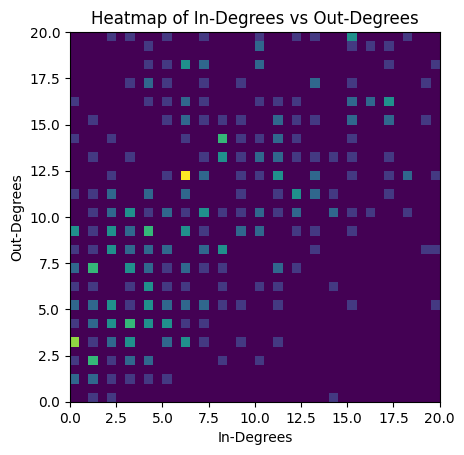

In [31]:
#Part B: Advanced tools
#3. heatmap 
x_val = list(in_deg.values())
y_val = list(out_deg.values())

heatmap, xedges, yedges = np.histogram2d(x_val, y_val, bins=40, range = [[0,20],[0,20]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.xlabel('In-Degrees')
plt.ylabel('Out-Degrees')
plt.title('Heatmap of In-Degrees vs Out-Degrees')
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

In [32]:
#5 - correlation with length of content

import scipy.stats as stats
#use the length of content and verify if there is a correlation with the in-degrees and out-degrees
word_counts = []
for node in rock_artists_graph.nodes():
    word_count_value = rock_artists_graph.nodes[node]['word_count']
    word_counts.append(word_count_value)

correlation_in_degree_length_of_content = stats.pearsonr(list(in_deg.values()), word_counts)
correlation_out_degree_length_of_content = stats.pearsonr(list(out_deg.values()), word_counts)

correlation_in_degree_length_of_content2 = stats.spearmanr(list(in_deg.values()), word_counts)
correlation_out_degree_length_of_content2 = stats.spearmanr(list(out_deg.values()), word_counts)

print(f"Using the Pearson correlation:\n")
print(f"The correlation between in-degrees and length of content is: ", correlation_in_degree_length_of_content.statistic)
print(f"The correlation between out-degrees and length of content is: ", correlation_out_degree_length_of_content.statistic)

print(f"\nUsing the Spearman correlation:\n")
print(f"The correlation between in-degrees and length of content is: ", correlation_in_degree_length_of_content2.statistic)
print(f"The correlation between out-degrees and length of content is: ", correlation_out_degree_length_of_content2.statistic)

Using the Pearson correlation:

The correlation between in-degrees and length of content is:  0.6715059646676972
The correlation between out-degrees and length of content is:  0.5613066449333682

Using the Spearman correlation:

The correlation between in-degrees and length of content is:  0.6242939145177122
The correlation between out-degrees and length of content is:  0.6790958470561627


In [33]:
deg_centrality = nx.degree_centrality(rock_artists_graph)
top5_deg_centrality = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print(f"Top 5 most central asrtist based on degree centrality: ")
for node, centrality in top5_deg_centrality:
    print(f"{node}: {centrality}")

betweenness_centrality = nx.betweenness_centrality(rock_artists_graph)
top5_betweenness_centrality =  sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print(f"\nTop 5 most central artist based on betweenness centrality: ")
for node, centrality in top5_betweenness_centrality:
    print(f"{node}: {centrality}")

Top 5 most central asrtist based on degree centrality: 
rock music: 0.5371900826446281
Led Zeppelin: 0.3078512396694215
Black Sabbath: 0.2809917355371901
Queen (band): 0.2747933884297521
Metallica: 0.2706611570247934

Top 5 most central artist based on betweenness centrality: 
rock music: 0.1641159775217649
Deep Purple: 0.03701095300534651
Led Zeppelin: 0.03325836899994176
Alice in Chains: 0.032408704479987456
Bob Dylan: 0.031120951611110375


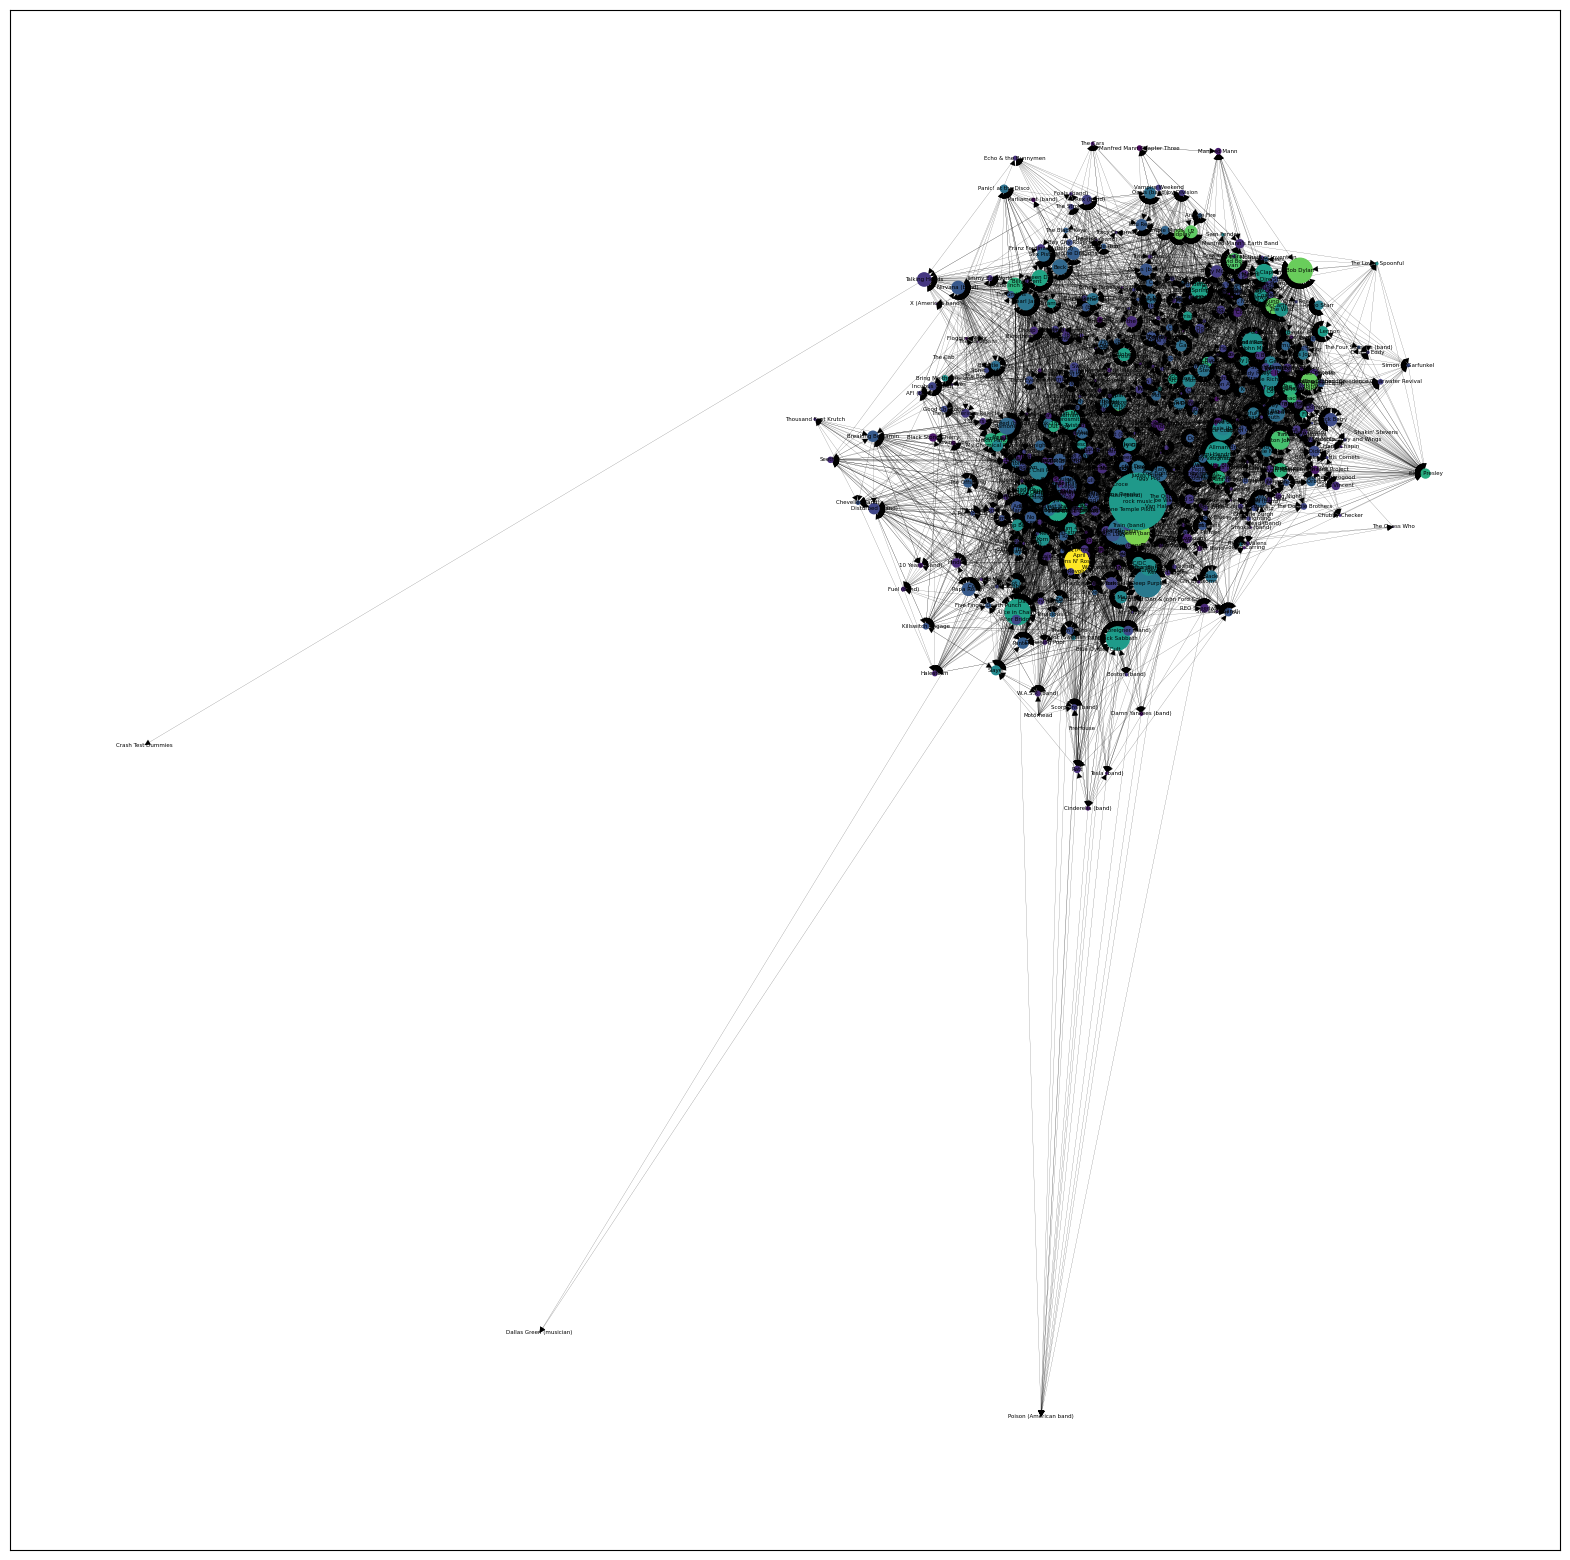

In [34]:
#node size based on betweenness centrality

betweenness_centrality = nx.betweenness_centrality(rock_artists_graph)
node_size_bc = [betweenness_centrality[node] * 10000 for node in rock_artists_graph.nodes()]

node_colors = []
for node in rock_artists_graph.nodes():
    grad_word_count = rock_artists_graph.nodes[node]['word_count']
    node_colors.append(grad_word_count)
    
pos = nx.forceatlas2_layout(rock_artists_graph, gravity = 10)
plt.figure(1, figsize=(20,20))
nx.draw_networkx(rock_artists_graph, pos, width=0.1, node_size = node_size_bc, node_color = node_colors, font_size= 4)

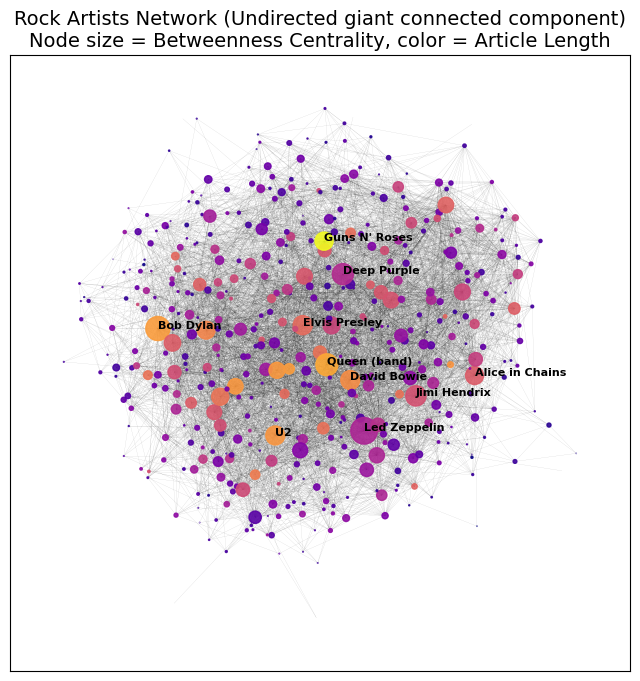

In [99]:

# Convert to undirected giant connected component
rock_artists_graph_undirected = rock_artists_graph.to_undirected()
largest_cc_nodes = max(nx.connected_components(rock_artists_graph_undirected), key=len)
giant_connected_component = rock_artists_graph_undirected.subgraph(largest_cc_nodes).copy()

# Betweenness centrality (undirected)
betweenness_centrality = nx.betweenness_centrality(giant_connected_component)
node_size_bc = [betweenness_centrality[node] * 8000 for node in giant_connected_component.nodes()]
node_colors = []
for node in rock_artists_graph.nodes():
    grad_word_count = rock_artists_graph.nodes[node]['word_count']
    node_colors.append(grad_word_count)

pos = nx.forceatlas2_layout(giant_connected_component, gravity=10)

plt.figure(figsize=(8,8))
nx.draw_networkx_nodes(
    giant_connected_component, pos,
    node_size=node_size_bc,
    node_color=node_colors,
    cmap="plasma",
    alpha=0.9
)
nx.draw_networkx_edges(giant_connected_component, pos, width=0.1, alpha=0.3)

#If we would show the label of all the nodes, it would be hard to read, so because of this reason we show only the 10 biggest node's label of the plot
top_labels = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for node, bc in top_labels:
    plt.text(
        pos[node][0],
        pos[node][1],
        node,
        fontsize=8,
        fontweight="bold",
        color="black"
    )

plt.title("Rock Artists Network (Undirected giant connected component)\nNode size = Betweenness Centrality, color = Article Length", fontsize=14)
plt.show()


In [35]:
#Find the 5 most central characters according to eigenvector centrality.

eigenvector_centrality_out = nx.eigenvector_centrality(rock_artists_graph, max_iter=1000, tol=1e-06)
top5_eigenvector_centrality_out = sorted(eigenvector_centrality_out.items(), key=lambda x: x[1], reverse=False)[:5]
print(f"\nTop 5 most central artist based on eigenvector centrality: ")
for node, centrality in top5_eigenvector_centrality_out:
    print(f"{node}: {centrality}")

undirected_rock_artist_graph = rock_artists_graph.to_undirected(reciprocal=False, as_view=True)

eigenvector_centrality_in = nx.eigenvector_centrality(undirected_rock_artist_graph, max_iter=1000, tol=1e-06)
top5_eigenvector_centrality_in = sorted(eigenvector_centrality_in.items(), key=lambda x: x[1], reverse=True)[:5]
print(f"\nTop 5 most central artist based on eigenvector centrality (inverted graph): ")
for node, centrality in top5_eigenvector_centrality_in:
    print(f"{node}: {centrality}")


Top 5 most central artist based on eigenvector centrality: 
Bachman–Turner Overdrive: 2.600344950816709e-27
Ben Folds Five: 2.600344950816709e-27
Blue October: 2.600344950816709e-27
Blue Öyster Cult: 2.600344950816709e-27
Bread (band): 2.600344950816709e-27

Top 5 most central artist based on eigenvector centrality (inverted graph): 
rock music: 0.2453787905393527
Led Zeppelin: 0.16199514076749436
Black Sabbath: 0.1422783568655026
Metallica: 0.14158814429028432
Queen (band): 0.1374348170159206


## Assignment 2

### Part 1: Analyze the network
The questions in this part are based on Lecture 5.

-  Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.
    - It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing.
    - I would like you to include concepts like centrality and assortativity in your analysis.
    - Use a network backbone in your analysis.
    - In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone).
    - **Note**: As I write above, an important part of the exercise consists is selecting the right elements of the lecture to create a meaningful analysis. So don't solve this part by going exhaustive and just calculating everything you can think of in one massive analysis. Try to focus on using what you've learned to characterize the network.

#### Analyze the network
- Degree distribution
- Centrality and assortavity analysis
- Use the network backcone
- Visualize the backbone

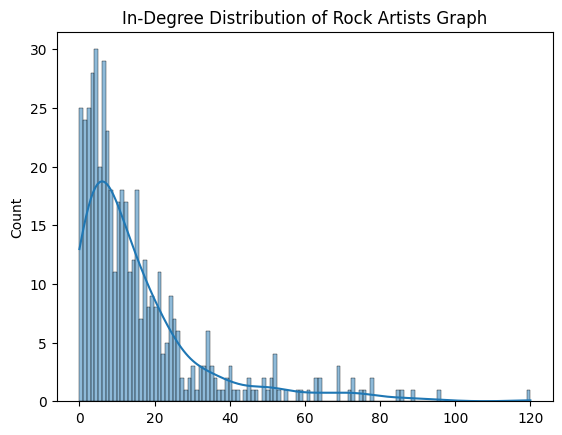

**Figure 1.1:** *In-Degree Distribution of Rock Artists Graph*

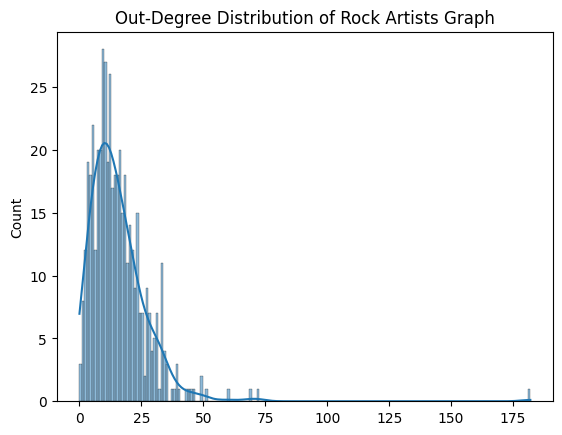

**Figure 1.2:** *Out-Degree Distribution of Rock Artists Graph*

In [36]:
#use basic concepts like degree distributions in analysis

from IPython.display import display_markdown
from IPython.display import display, Markdown

def plot_degree_distribution(degrees, title):
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.histplot(degrees, bins=(max(degrees) - min(degrees) + 1), kde=True)
    plt.title(title)
    plt.show()
    

plot_degree_distribution(rock_artists_graph_attributes["in_degrees"], "In-Degree Distribution of Rock Artists Graph")
display(Markdown("**Figure 1.1:** *In-Degree Distribution of Rock Artists Graph*"))

plot_degree_distribution(rock_artists_graph_attributes["out_degrees"], "Out-Degree Distribution of Rock Artists Graph")
display(Markdown("**Figure 1.2:** *Out-Degree Distribution of Rock Artists Graph*"))


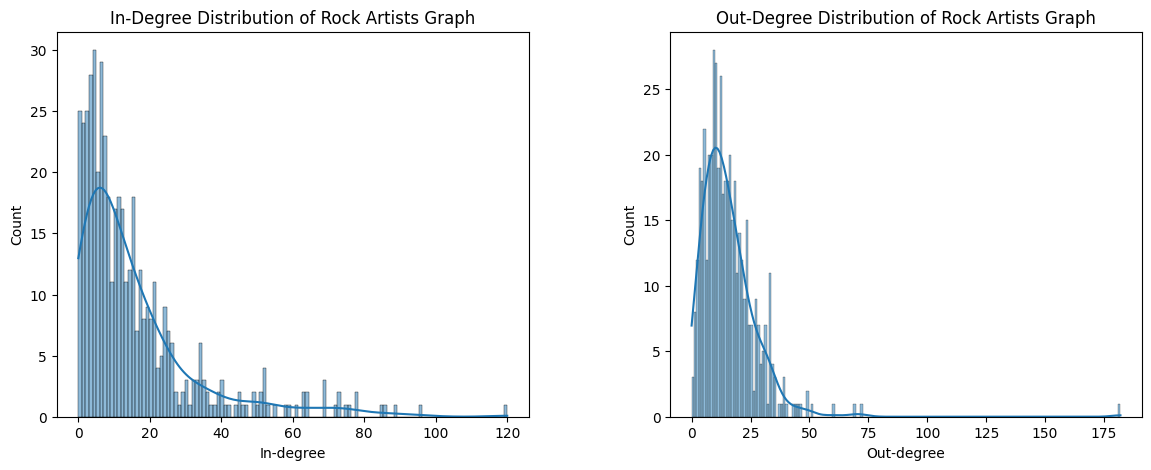

**Figure 1.1:** *In-Degree Distribution of Rock Artists Graph*

**Figure 1.2:** *Out-Degree Distribution of Rock Artists Graph*

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

in_deg = rock_artists_graph_attributes["in_degrees"]
out_deg = rock_artists_graph_attributes["out_degrees"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(in_deg, bins=max(in_deg) - min(in_deg) + 1, kde=True, ax=axes[0])
axes[0].set_title("In-Degree Distribution of Rock Artists Graph")
axes[0].set_xlabel("In-degree")
axes[0].set_ylabel("Count")


sns.histplot(out_deg, bins=max(out_deg) - min(out_deg) + 1, kde=True, ax=axes[1])
axes[1].set_title("Out-Degree Distribution of Rock Artists Graph")
axes[1].set_xlabel("Out-degree")
axes[1].set_ylabel("Count")

plt.subplots_adjust(wspace=0.3)
plt.show()

display(Markdown("**Figure 1.1:** *In-Degree Distribution of Rock Artists Graph*"))
display(Markdown("**Figure 1.2:** *Out-Degree Distribution of Rock Artists Graph*"))


In [100]:
# Degree centrality
deg_cent = nx.degree_centrality(rock_artists_graph)
print(sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5])

# Betweenness centrality
bet_cent = nx.betweenness_centrality(rock_artists_graph)
print(sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)[:5])

# Eigenvector centrality (directed)
eig_cent_in = nx.eigenvector_centrality(rock_artists_graph, max_iter=1000)
print(sorted(eig_cent_in.items(), key=lambda x: x[1], reverse=True)[:5])


[('Led Zeppelin', 0.30434782608695654), ('Black Sabbath', 0.27950310559006214), ('Queen (band)', 0.2732919254658385), ('Metallica', 0.26915113871635615), ('Bob Dylan', 0.2567287784679089)]
[('Deep Purple', 0.04328761792645038), ('Queen (band)', 0.03973736999660883), ('Alice in Chains', 0.036860106969053424), ("Guns N' Roses", 0.03630642173933055), ('Jimi Hendrix', 0.03398917778239813)]
[('Led Zeppelin', 0.2311608378471955), ('Black Sabbath', 0.19389740387918397), ('Queen (band)', 0.18215207768672), ('Metallica', 0.18091295084493206), ('David Bowie', 0.15963732159110777)]


# Part C: Backbones and Network Visualization 

One method to clean up the "hairball"-looking networks, is known as the [backbone method](https://www.pnas.org/doi/10.1073/pnas.0808904106). Sometimes this method is also called the "disparity filter". I explain what it's all about in the video below.

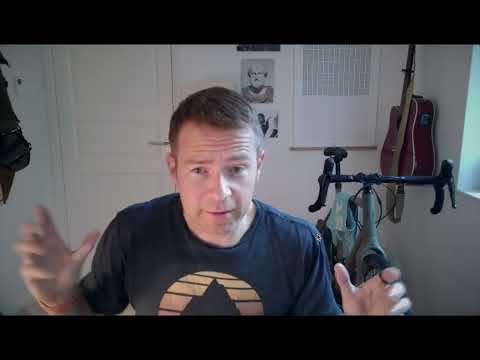

In [37]:
YouTubeVideo("GOvsrVulbsg", width=800, height=450)

There are [many backbone extraction algorithms](https://www.michelecoscia.com/?page_id=287), and I've chosen to talk about the *Disparity Filter* here, because it's the oldest and most commonly used method (so I though you should know about it). Plus, it'll probably be the relevant method for your project.

This choice, however, presents us with a problem: As I explain in the video, the Disparity Filter method *only works on weighted networks*. But our network does not have edge weights in any kind of natural way (since there's usually just a single link between two wiki pages). 


So to get rid of unimportant edges, we'll have to try something different. I present you with three possible methods below. For the first two ones, we'll add weights proportional to the [edge betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.edge_betweenness_centrality.html). The edge betweenness centrality is just like the node betweenness centrality that you know and love ... only that it's defined for *edges* instead of nodes.

We can create two new weighted networks based on the edge betweenness
 * **Weighted Network 1**: The ***undirected*** Rock Music Network (Giant Connected Component) but with edge weights proportional to the edge betweenness centrality (let's renormalize so that the lowest weight is equal to 1 and the highest weight is equal to 100).
 * **Weighted Network 2**: The ***undirected*** Rock Music Network  (Giant Connected Component) but with edge weights proportional to 1/(edge weight in Weighted Network 1).

The third strategy (resulting in **Weighted network 3**) is to use a method designed for extracting structure from undirected networks: The [**High-Salience Skeleton**](https://www.nature.com/articles/ncomms1847). It's implemented as part of [this backbone extraction package](https://www.michelecoscia.com/?page_id=287)


Now we're ready for the exercise.


*Exercise 5*: Visualizing the Network Backbone

> 1. Extract the network backbone for both Weighted Network 1, 2, and 3. You can implement the disparity filter yourself based on the [scientific paper](https://www.pnas.org/doi/10.1073/pnas.0808904106) or find an implentation on GitHub (there are several ones to choose from ... I like [this implementation](https://www.michelecoscia.com/?page_id=287), which also includes other interesting edge filters). Figure out how your particular backbone extractor works (you may have to inspect the code itself, these packages are not always well documented). Play around with values of $\alpha$ to get an aestetically pleasing visualization (but don't make the resulting network too sparse).
> 2. Plot the resulting three networks using ForceAtlas2, still sizing nodes according to total degree. No need to color them. If your backbone has some disconnected nodes, feel free to not plot them. And remember to calculate a new layout to see how the structure has changed.
> 3. Comment on your results
>    * Do you see any structures in the networks now? Inspect some nodes to get a sense of what the structures captures in the three networks. Describe your findings in your own words.
>    * Weighted network 1, 2, and 3 are very different. In 1 and 2, we have removed edges with low/high edge betweenness centrality respectively and HSH is based on shortest paths. What have the various filters done to the networks? Describe what you see visually, and your explain your thoughts on what we've done to the network structures.

<div class="alert alert-block alert-info">
There's a lot to do today, so knock youself out with your LLM for this exercise, hopefully it can make your life easier (although I hope you'll do a bit of your own thinking, since a lot of complicated conceptual things are going on with the interplay between the backboning and edge betweenness and inverse edge betweenness!)</div>

One final thing. For now, the backbones are mostly for visualization. Especially because the edge weights are a bit artificial. Generally, it's not exactly clear what kind of information we get rid off when removing the non-backbone edges -- and in our case it's even less clear because I've made up two of the methods. Thus, we'll still do the exercises during the following weeks using the full network that preserves all of the connection information.


In [38]:
#5 - correlation with length of content

import scipy.stats as stats
#use the length of content and verify if there is a correlation with the in-degrees and out-degrees
word_counts = []
for node in rock_artists_graph.nodes():
    word_count_value = rock_artists_graph.nodes[node]['word_count']
    word_counts.append(word_count_value)

correlation_in_degree_length_of_content = stats.pearsonr(list(in_deg.values()), word_counts)
correlation_out_degree_length_of_content = stats.pearsonr(list(out_deg.values()), word_counts)

correlation_in_degree_length_of_content2 = stats.spearmanr(list(in_deg.values()), word_counts)
correlation_out_degree_length_of_content2 = stats.spearmanr(list(out_deg.values()), word_counts)

print(f"Using the Pearson correlation:\n")
print(f"The correlation between in-degrees and length of content is: ", correlation_in_degree_length_of_content.statistic)
print(f"The correlation between out-degrees and length of content is: ", correlation_out_degree_length_of_content.statistic)

print(f"\nUsing the Spearman correlation:\n")
print(f"The correlation between in-degrees and length of content is: ", correlation_in_degree_length_of_content2.statistic)
print(f"The correlation between out-degrees and length of content is: ", correlation_out_degree_length_of_content2.statistic)

Using the Pearson correlation:

The correlation between in-degrees and length of content is:  0.6715059646676972
The correlation between out-degrees and length of content is:  0.5613066449333682

Using the Spearman correlation:

The correlation between in-degrees and length of content is:  0.6242939145177122
The correlation between out-degrees and length of content is:  0.6790958470561627


In [39]:
deg_centrality = nx.degree_centrality(rock_artists_graph)
top5_deg_centrality = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print(f"Top 5 most central asrtist based on degree centrality: ")
for node, centrality in top5_deg_centrality:
    print(f"{node}: {centrality}")

betweenness_centrality = nx.betweenness_centrality(rock_artists_graph)
top5_betweenness_centrality =  sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print(f"\nTop 5 most central artist based on betweenness centrality: ")
for node, centrality in top5_betweenness_centrality:
    print(f"{node}: {centrality}")

Top 5 most central asrtist based on degree centrality: 
rock music: 0.5371900826446281
Led Zeppelin: 0.3078512396694215
Black Sabbath: 0.2809917355371901
Queen (band): 0.2747933884297521
Metallica: 0.2706611570247934

Top 5 most central artist based on betweenness centrality: 
rock music: 0.1641159775217649
Deep Purple: 0.03701095300534651
Led Zeppelin: 0.03325836899994176
Alice in Chains: 0.032408704479987456
Bob Dylan: 0.031120951611110375


In [40]:
#We create a weighted undirected graph based on the betweenness centrality
weighted_rock_artist_graph1 = rock_artists_graph.to_undirected(reciprocal=False, as_view=True)

### Weighted network 1

We chose Weighted Network 1 because it uses edge betweenness centrality to set the weights.
This means that edges that connect important parts of the network get higher values.
It helps to keep the most meaningful connections and makes the main structure of the Rock Artists network clearer.

In [84]:
#We calculate the betweenness centrality for each node. It shows how often a node appears on the shortest paths between other nodes in the network.
betweenness_centrality_w1 = nx.betweenness_centrality(weighted_rock_artist_graph1)

#we find the maximum and minimum betweenness centrality values, so later we can normalize the values between 1 and 100
max_bc1 = max(betweenness_centrality_w1.values())
min_bc1 = min(betweenness_centrality_w1.values())

#We loop through each egdge from u to v. u is the source node and v is the target node
for u, v in weighted_rock_artist_graph1.edges():
    #the source_bc variable shows how important the connetion is
    source_bc1 = betweenness_centrality_w1[u]

    if max_bc1 == min_bc1:
        weight = 1.0
    else:
        #We normalize the weight between 1 and 100
        weight = 1 + (source_bc1 - min_bc1) / (max_bc1 - min_bc1)*99
    #We assign the weight to the edge
    weighted_rock_artist_graph1[u][v]['weight'] = weight



In [85]:
#assortavity coefficient of weighted network 1

assortavity_coefficient_w1 = nx.degree_assortativity_coefficient(weighted_rock_artist_graph1)
print("The assortavity coefficient of the weighted rock artists graph based on betweenness centrality is: ", assortavity_coefficient_w1)

The assortavity coefficient of the weighted rock artists graph based on betweenness centrality is:  0.0033467758033124497


The assortavity coefficient shows, that the nodes connect to other nodes with different properies.

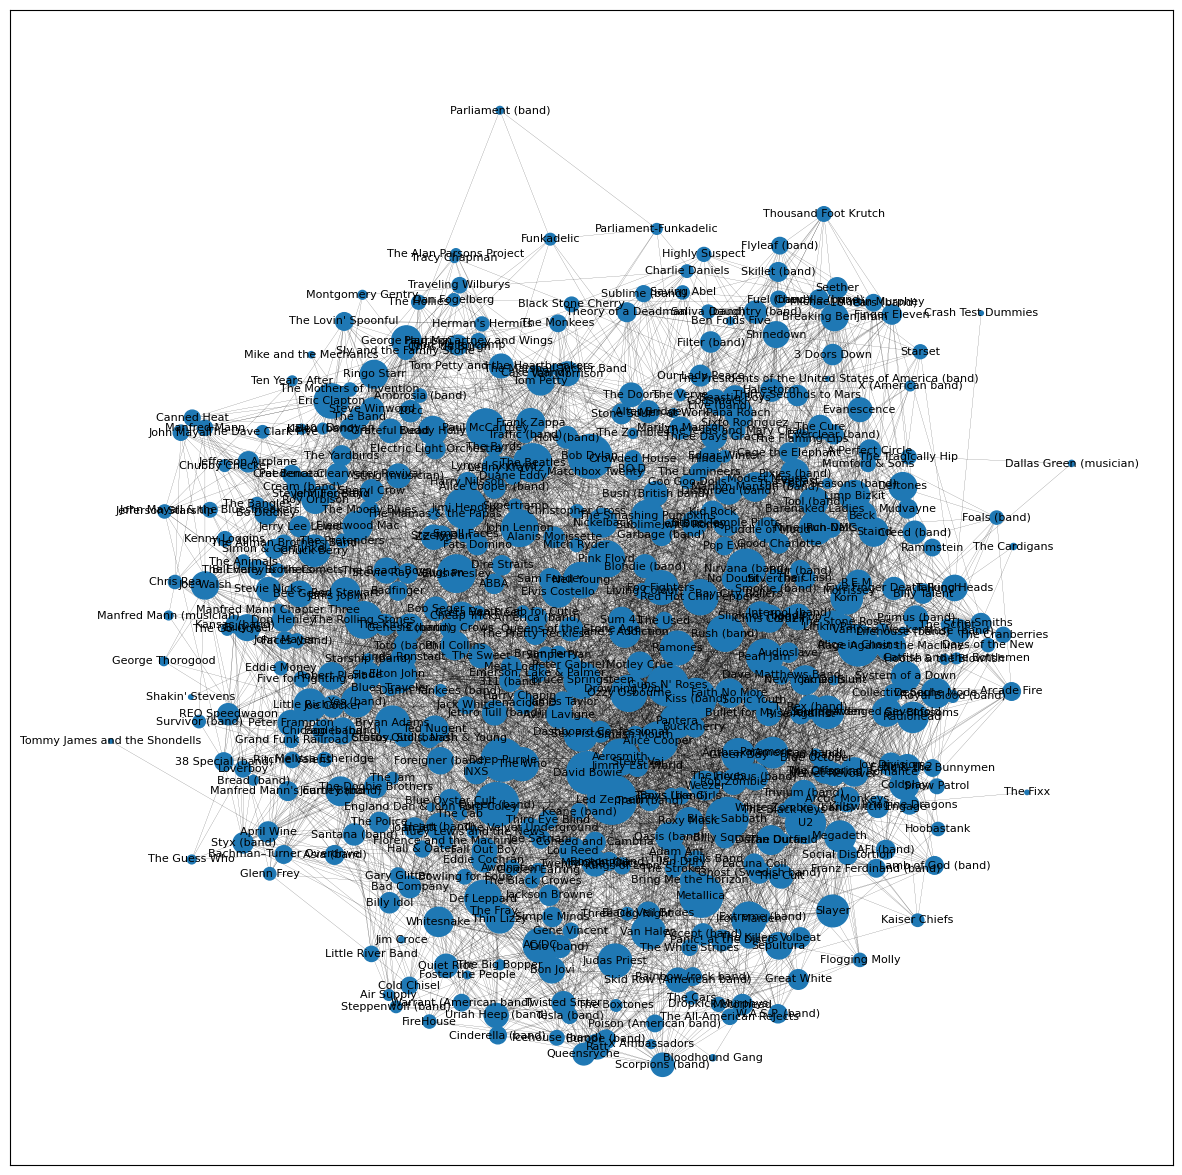

**Figure 2:** *Plot of the weighted rock artist graph based on the betweenness centrality*

In [94]:
#plotting the network using forceatlas2 layout, the size according to the total degree.

node_size_total_degree = [weighted_rock_artist_graph1.degree(node) * 10 for node in weighted_rock_artist_graph1.nodes()]

pos = nx.forceatlas2_layout(weighted_rock_artist_graph1, gravity = 10)
plt.figure(1, figsize=(15,15))
nx.draw_networkx(weighted_rock_artist_graph1, pos, width=0.1, node_size = node_size_total_degree, font_size= 8)
plt.show()
display(Markdown("**Figure 2:** *Plot of the weighted rock artist graph based on the betweenness centrality*"))

### Weighted network 2

In [44]:
weighted_rock_artist_graph2 = rock_artists_graph.to_undirected(reciprocal=False, as_view=True)

for u, v in weighted_rock_artist_graph2.edges():
    weighted_rock_artist_graph2[u][v]['weight'] = 1/ weighted_rock_artist_graph1[u][v]['weight']

In [95]:
#We calculate the betweenness centrality on the weighted graph 2
betweenness_centrality_w2 = nx.betweenness_centrality(weighted_rock_artist_graph2)

max_bc2 = max(betweenness_centrality_w2.values())
min_bc2 = min(betweenness_centrality_w2.values()) 

for i, v in weighted_rock_artist_graph2.edges():
    source_bc2 = betweenness_centrality_w2[i]

    if max_bc2 == min_bc2:
        weight = 1.0
    else:
        weight = 1 + (source_bc2 - min_bc2) / (max_bc2 - min_bc2)*99
    weighted_rock_artist_graph2[i][v]['weight'] = weight



In [ ]:
#We calculate the betweenness centrality on the weighted graph 2
betweenness_centrality_w2 = nx.betweenness_centrality(weighted_rock_artist_graph2)

max_bc2 = max(betweenness_centrality_w2.values())
min_bc2 = min(betweenness_centrality_w2.values()) 

for i, v in weighted_rock_artist_graph2.edges():
    source_bc2 = betweenness_centrality_w2[i]

    if max_bc2 == min_bc2:
        weight = 1.0
    else:
        weight = 1 + (source_bc2 - min_bc2) / (max_bc2 - min_bc2)*99
    weighted_rock_artist_graph2[i][v]['weight'] = weight



In [46]:
#we create a table. 3 column: src, trg, weight
#we use tab as separator
#we save the table to a csv file
import pandas as pd
edge_data = []
with open("./weighted_network1.txt", "w", encoding="utf-8") as f:
    f.write("src\ttrg\tweight\n")
    for u, v , data in weighted_rock_artist_graph1.edges(data=True):
        weight = data.get('weight', 1.0)
        f.write(f"{u}\t{v}\t{data['weight']}\n")
        edge_data.append({"src": u, "trg": v, "nij": weight})

df = pd.DataFrame(edge_data)
df.to_csv("./weighted_rock_artists_graph_bc.csv", sep="\t", index=False)
        

In [47]:
# df

In [48]:
import backboning as bn

df_edges, _, _ = bn.read("./weighted_rock_artists_graph_bc.csv", "nij")

In [49]:
backbone_w1 = bn.disparity_filter(df_edges)

Calculating DF score...


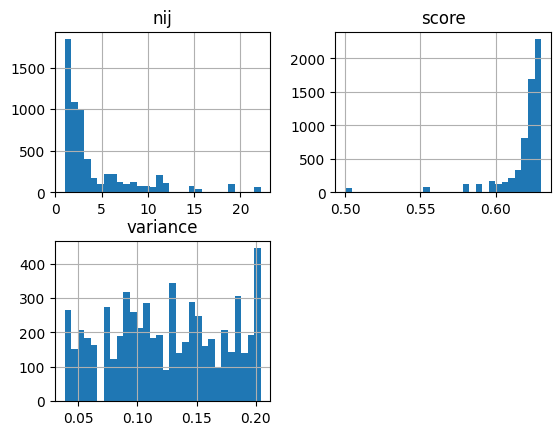

In [50]:
import matplotlib.pyplot as plt

backbone_w1[backbone_w1['score'] > 0].hist(bins=30)  # You can adjust the number of bins
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Scores')
plt.show()

In [ ]:
import pandas as pd
import networkx as nx
from backboning import disparity_filter

# disparity_filter expects column name 'nij'
df_edges = df_edges.rename(columns={'weight': 'nij'})

backbone_df = disparity_filter(df_edges)    
# returns columns ['src','trg','nij','score',...]
# threshold by score (0.62) 
# The 0.62 threshold was chosen to retain only the most significant edges in the disparity filter,
# removing weak/noisy links while preserving the main structure of the network for analysis.
backbone_df = backbone_df[backbone_df['score'] > 0.62]


Calculating DF score...


To extract the network backbone, we applied the Disparity Filter method on the weighted Rock Artists network.
The algorithm assigns a significance score to each edge and keeps only the statistically relevant ones.
Using a threshold of alpha = 0.62, we retained approximately 69% of the original edges, focusing on the most meaningful connections in the network structure.

In [52]:

# create network using the backbone 'score' (or 'nij' if you prefer)
backbone_w1 = nx.from_pandas_edgelist(backbone_df, source="src", target="trg", edge_attr="score")

print("Number of edges in the original graph:", weighted_rock_artist_graph1.number_of_edges())
print("Number of edges in the backbone:", backbone_w1.number_of_edges())

Number of edges in the original graph: 6215
Number of edges in the backbone: 4313


After we applied the Disparity Filter, we created a new backbone network using the significant edges only.
The resulting backbone contains fewer edges than the original graph, keeping only the most relevant connections that represent the core structure of the network.

In [53]:
#we visualize the network
#plotting the network using forceatlas2 layout, the size according to the total degree.

# node_size_total_degree = [weighted_rock_artist_graph1.degree(node) * 10 for node in weighted_rock_artist_graph1.nodes()]

# pos = nx.forceatlas2_layout(weighted_rock_artist_graph1, gravity = 10)
# plt.figure(1, figsize=(15,15))
# nx.draw_networkx(weighted_rock_artist_graph1, pos, width=0.1, node_size = node_size_total_degree, font_size= 8)
# plt.show()
# display(Markdown("**Figure 2:** *Plot of the weighted rock artist graph based on the betweenness centrality*"))


In [54]:
import pandas as pd
import networkx as nx
from backboning import disparity_filter

# disparity_filter expects column name 'nij'
# df_edges = df_edges.rename(columns={'weight': 'nij'})
df_edges = df_edges.rename(columns={"weight": "nij"})


backbone_df = disparity_filter(df_edges)                  
# returns columns ['src','trg','nij','score',...]
# optional: threshold by score (choose alpha you like)
backbone_df = backbone_df[backbone_df['score'] > 0.62]

# create network using the backbone 'score' (or 'nij' if you prefer)
backbone_w1 = nx.from_pandas_edgelist(backbone_df, source="src", target="trg", edge_attr="score")

print("Number of edges in the original graph:", weighted_rock_artist_graph1.number_of_edges())
print("Number of edges in the backbone:", backbone_w1.number_of_edges())

Number of edges in the original graph: 6215
Number of edges in the backbone: 4313


Calculating DF score...


Using the disparity filter (that was mentioned in the lecture document, that is the reason why we used that), we extracted the backbone from the network. The original graph contained 6215 edges, and after applying the significance treshold of 0.62, in the end around 69% of the edges remained (=4313 edges).


In [98]:
#We compare the  the network and the backbone

#Density
original_density = nx.density(weighted_rock_artist_graph1)
backbone_density = nx. density(backbone_w1)
print(f"The density of the original network: {original_density}.\n and the density of the backbone: {backbone_density}")


#Compare average degree
original_avg_degree = sum(dict(weighted_rock_artist_graph1.degree()).values()) / weighted_rock_artist_graph1.number_of_nodes()
backbone_deg = sum(dict(backbone_w1.degree()).values()) / backbone_w1.number_of_nodes()

print(f"The average degree before: {original_avg_degree}\n The average degree after: {backbone_deg}")
print(f"The edges reduced by: {(1 - backbone_w1.number_of_edges() / weighted_rock_artist_graph1.number_of_edges()):.2%}")

The density of the original network: 0.051169515596393066.
 and the density of the backbone: 0.0403261245593859
The average degree before: 24.714876033057852
 The average degree after: 18.630669546436284
Edges reduced by: 27.89%


After applying the Disparity Filter, the network became a bit sparser. The density dropped from 0.053 to 0.040, and the average degree decreased from 25.6 to 18.6. This means the backbone kept the most important connections and removed the weaker ones.

In [56]:
original_nodes = weighted_rock_artist_graph1.number_of_nodes()
original_edges = weighted_rock_artist_graph1.number_of_edges()

backbone_nodes = backbone_w1.number_of_nodes()
backbone_edges = backbone_w1.number_of_edges()

print(f"The original network's number of edges: {original_edges}, and nodes: {original_nodes}\n the Backbone's number of edges: {backbone_edges}, and nodes: {backbone_nodes}")
#connected components
n_components_original = nx.number_connected_components(weighted_rock_artist_graph1)
n_components_backbone = nx.number_connected_components(backbone_w1)

# weakly_coponents_original = nx.number_weakly_connected_components(weighted_rock_artist_graph1)
# print(n_components_original, n_components_backbone, weakly_coponents_original)
print(f"The connectec components {n_components_original}")

The original network's number of edges: 6215, and nodes: 485
 the Backbone's number of edges: 4313, and nodes: 463
The connectec components 1


### Network analysis

In [59]:
n_nodes = rock_artists_graph.number_of_nodes()
n_edges = rock_artists_graph.number_of_edges()
print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")

print("Is directed:", nx.is_directed(rock_artists_graph))

rock_artists_graph_undirected = rock_artists_graph.to_undirected()

largest_cc_nodes = max(nx.connected_components(rock_artists_graph_undirected), key=len)
giant_connected_component = rock_artists_graph_undirected.subgraph(largest_cc_nodes).copy()


print(f"GCC nodes: {giant_connected_component.number_of_nodes()}")
print(f"GCC edges: {giant_connected_component.number_of_edges()}")
print(f"GCC density: {nx.density(giant_connected_component):.4f}")

density = nx.density(rock_artists_graph)
avg_degree = sum(dict(rock_artists_graph.degree()).values()) / n_nodes

print(f"Network density: {density:.4f}")
print(f"Average degree: {avg_degree:.2f}")


Number of nodes: 485
Number of edges: 7507
Is directed: True
GCC nodes: 485
GCC edges: 6215
GCC density: 0.0530
Network density: 0.0320
Average degree: 30.96


Our directed network contains 485 nodes and 7507 edges. Each node represents a rock band, and the edges corresponds to hyperlinks between their Wikipedia pages. For analysis we often use its largest undirected connected component (GCC), which includes 485 nodes and 6215 edges, with a density of 0.53.
Overall, the network is sparse, it's density is around 0.03, and the average degreeof approximately 31, indicates that most artists are connected to a moderate number of others, while a few very connected hubs likely dominate its structure.

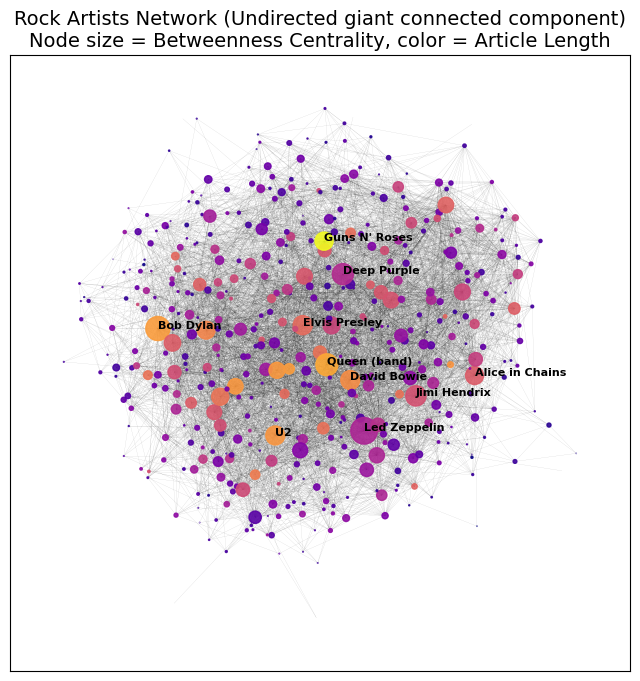

In [ ]:

# Convert to undirected giant connected component
rock_artists_graph_undirected = rock_artists_graph.to_undirected()
largest_cc_nodes = max(nx.connected_components(rock_artists_graph_undirected), key=len)
giant_connected_component = rock_artists_graph_undirected.subgraph(largest_cc_nodes).copy()

# Betweenness centrality (undirected)
betweenness_centrality = nx.betweenness_centrality(giant_connected_component)
node_size_bc = [betweenness_centrality[node] * 8000 for node in giant_connected_component.nodes()]
node_colors = []
for node in rock_artists_graph.nodes():
    grad_word_count = rock_artists_graph.nodes[node]['word_count']
    node_colors.append(grad_word_count)

pos = nx.forceatlas2_layout(giant_connected_component, gravity=10)

plt.figure(figsize=(8,8))
nx.draw_networkx_nodes(
    giant_connected_component, pos,
    node_size=node_size_bc,
    node_color=node_colors,
    cmap="plasma",
    alpha=0.9
)
nx.draw_networkx_edges(giant_connected_component, pos, width=0.1, alpha=0.3)

#If we would show the label of all the nodes, it would be hard to read, so because of this reason we show only the 10 biggest node's label of the plot
top_labels = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for node, bc in top_labels:
    plt.text(
        pos[node][0],
        pos[node][1],
        node,
        fontsize=8,
        fontweight="bold",
        color="black"
    )

plt.title("Rock Artists Network (Undirected giant connected component)\nNode size = Betweenness Centrality, color = Article Length", fontsize=14)
plt.show()


### Backbone

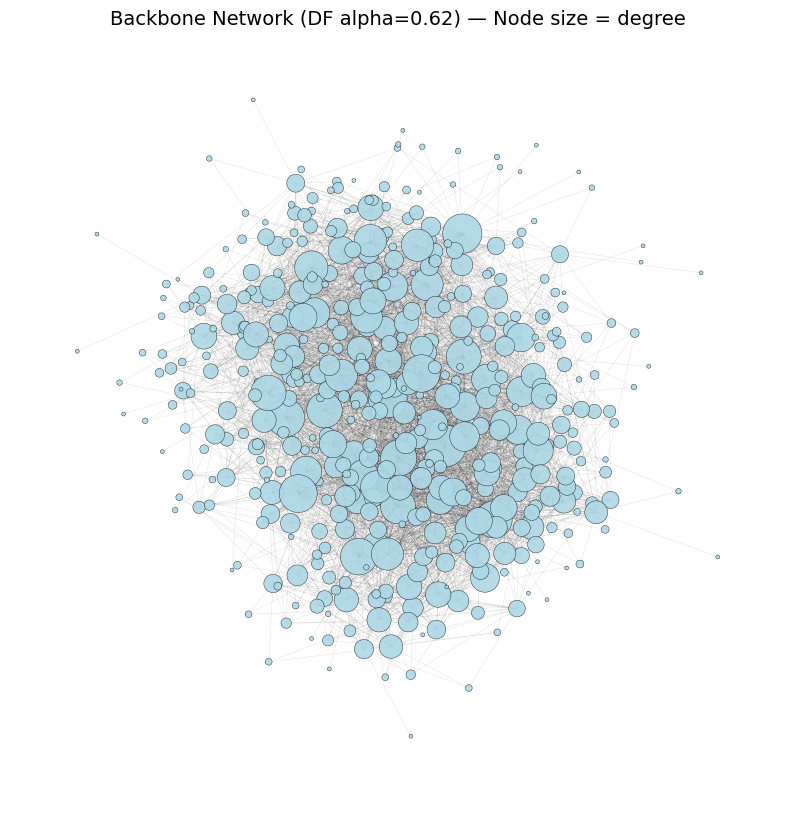

In [109]:
# Assignment-compliant backbone plot (no color, size = total degree)
bb_nodes = max(nx.connected_components(backbone_w1), key=len)
BB = backbone_w1.subgraph(bb_nodes).copy()

node_size_deg_bb = [BB.degree(n) * 8 for n in BB.nodes()]
pos_bb = nx.forceatlas2_layout(BB, gravity=10)

plt.figure(figsize=(10,10))
nx.draw_networkx_edges(BB, pos_bb, width=0.15, alpha=0.25, edge_color="black")
nx.draw_networkx_nodes(
    BB, pos_bb,
    node_size=node_size_deg_bb,
    node_color="lightblue",
    edgecolors="black",
    linewidths=0.3,
    alpha=0.9
)
plt.title("Backbone Network (DF alpha=0.62) — Node size = degree", fontsize=14)
plt.axis('off')
plt.show()


In [120]:
bc_back = nx.betweenness_centrality(backbone_w1)

#We print out only the first 5 results, to avoid printing out a long list
for node, value in list(bc_back.items())[:5]:
    print(f"{node}: {value}")


10cc: 0.002683306000831719
The Hollies: 0.00010633506048585414
Eric Clapton: 0.01765360859028401
rock music: 0.04009164346170857
Paul McCartney: 0.021024617895746518


This code measures how much each node (artist) acts as a bridge between others in the network, then displays the first 5 results to illustrate the concept without printing the full dataset.

In [112]:
clust_orig = nx.average_clustering(weighted_rock_artist_graph1.to_undirected())
clust_back = nx.average_clustering(backbone_w1)
print(f"Clustering before: {clust_orig:.3f}, after: {clust_back:.3f}")


Clustering before: 0.234, after: 0.293


The average clustering increased from 0.234 to 0.293 after we applied the disparity filter.
This means that the backbone network became weaker, random links were removed, while strong, meaningful connections within communities were preserved.
As a result, the remaining nodes form tighter clusters, highlighting the core community structure of the rock artist network.

In [113]:
assort_back = nx.degree_assortativity_coefficient(backbone_w1)
print(f"Degree assortativity of the backbone: {assort_back:.3f}")


Degree assortativity of the backbone: -0.160


The assortativity value of -0.160 means the backbone network is disassortative. Popular or well-connected nodes tend to link with smaller, less connected ones instead of other big hubs.

In [115]:
deg_values = []
for node, degree in backbone_w1.degree():
    if degree > 0:
        deg_values.append(degree)

fit_backbone = powerlaw.Fit(deg_values, discrete=True)
print(f"Alpha (backbone): {fit_backbone.power_law.alpha:.2f}, xmin: {fit_backbone.power_law.xmin}")

fit_backbone = powerlaw.Fit(deg_values, discrete=True)
print(f"Alpha (backbone): {fit_backbone.power_law.alpha:.2f}, xmin: {fit_backbone.power_law.xmin}")


Calculating best minimal value for power law fit
Alpha (backbone): 3.37, xmin: 34.0
Calculating best minimal value for power law fit
Alpha (backbone): 3.37, xmin: 34.0


For nodes with a degree above 34, the degree distribution roughly follows a power-law pattern, but with a relatively steep slope (since alpha > 3).
A higher α value indicates that very high-degree nodes are rare, so the network is less dominated by superhubs compared to a classic scale-free network.